In [ ]:
# BoolODE_data.ipynb
#
# Bryan Daniels
# 2023.2.27
#
# Testing our proposed methods on simulated RNA-seq data from the following paper:
#
# Pratapa, Aditya, Amogh P. Jalihal, Jeffrey N. Law, Aditya Bharadwaj, and T. M. Murali. 
# “Benchmarking Algorithms for Gene Regulatory Network Inference from Single-Cell Transcriptomic Data.” 
# Nature Methods 17, no. 2 (February 2020): 147–54. https://doi.org/10.1038/s41592-019-0690-6.
#

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# the control-kernel branch of Collective-Logic-Lab's Neet includes the modularity code
import neet.modularity as md

In [2]:
%load_ext autoreload
%autoreload 2

In [219]:
# 2023.3.6 taken from landau-paper-analysis.ipynb
from landau.landauAnalysis import principalComponents
from landau.landauAnalysis import LandauTransitionDistributionRelativeLogPDF
def bistablePlot(finalStates,vec,Jvals,Jvecs,c,d,nuMu,returnData=False,plotTheory=True,plotGaussian=True,
                **histKwargs):
    
    # calculate projection along eigenvector
    
    if (len(vec) == 1) and (finalStates.shape[1] > 1):
        # compute principal eigenvector manually if we're given a vec from a projected analysis
        PCAvals,PCAvecs = principalComponents(finalStates)
        projVec = PCAvecs[0]
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = np.mean(x)
    else:
        projVec = vec
        
        sampleMean = finalStates.mean()
        x = np.dot(finalStates-sampleMean,projVec)
        
        meanFinalState = sampleMean
    
    
    # plot histogram of data
    plt.hist(x,density=True,bins=30,**histKwargs)

    if plotTheory:
        # plot inferred relative log-likelihood
        xRange = 1.5*(x.max() - x.min())
        plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,xRange=xRange)
        
    if plotGaussian:
        # compare to Gaussian null model
        xVals = np.linspace(-xRange/2.,xRange/2.,500)
        distGaussian = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                            meanFinalState + xVal*vec,   
                            meanFinalState,
                            Jvals,
                            Jvecs,
                            vec,
                            1.,
                            0.)) for xVal in xVals ]
        distGaussian = distGaussian / (np.sum(distGaussian)*(np.diff(xVals)[0]))
        plt.plot(xVals,distGaussian,lw=2,color='black',label='Gaussian mixture fit')

    plt.xlabel('Gene expression\nalong bistable dimension')
    plt.ylabel('Probability')

    if returnData:
        return {'x': x,
                'vec': vec,
                'mu': mu,
                'runIndex': runIndex,
                'meanFinalState': meanFinalState,
                }
    
def plotLandauTheory(vec,Jvals,Jvecs,c,d,nuMu,color='crimson',lw=5,zorder=10,xRange=20):
    """
    (x = 0 corresponds to the mean value along the projected axis)
    """
    xVals = np.linspace(-xRange/2.,xRange/2.,500)

    dist = [ np.exp(LandauTransitionDistributionRelativeLogPDF(
                        xVal*vec,   
                        nuMu*vec,
                        Jvals,
                        Jvecs,
                        vec,
                        c,
                        d)) for xVal in xVals ]
    dist = dist / (np.sum(dist)*(np.diff(xVals)[0]))
    plt.plot(xVals,dist,lw=lw,color=color,zorder=zorder,label='Landau fit')

In [3]:
dataDir = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Super-Secret-Project-CK2/'\
                         'data/230227/BEELINE-data/'
exptDir = 'inputs/Curated/GSD/GSD-2000-1-70/'

In [4]:
expression = pd.read_csv(dataDir+exptDir+'ExpressionData.csv',
                         index_col=0).T

In [5]:
times_raw = pd.read_csv(dataDir+exptDir+'PseudoTime.csv',
                       index_col=0)
times_raw['time'] = np.sum(np.nan_to_num(times_raw),axis=1)
times = times_raw['time']

In [6]:
expression

,AMH,CBX2,CTNNB1,DHH,DKK1,DMRT1,FGF9,FOXL2,GATA4,NR0B1,NR5A1,PGD2,RSPO1,SOX9,SRY,UGR,WNT4,WT1mKTS,WT1pKTS
E801_438,0.338789,0.002717,0.011462,0.353490,1.847789,0.000000,0.552496,0.000000,0.000000,1.859390,2.479147,0.497765,0.000000,0.000000,2.173483,0.000000,0.015687,0.000000,1.742427
E1_769,1.841659,0.000000,0.005118,2.554467,2.208555,2.207165,1.708263,0.000000,2.257457,0.000000,2.175349,2.187490,0.000000,2.053794,2.022430,0.042965,0.000000,0.000000,2.694481
E1795_733,0.000000,0.000000,1.845364,0.000000,0.000000,0.000000,0.000000,2.329127,0.000000,1.992085,0.002785,0.000000,2.011789,0.000000,0.000000,0.000000,1.868029,0.000000,0.000000
E645_767,1.704565,0.000000,0.011418,2.252899,1.713882,1.683637,1.753460,0.000000,0.000000,0.013730,0.000000,1.927144,0.000000,0.000000,2.389513,0.000000,0.008643,2.239090,1.723586
E487_58,0.000000,2.653297,0.000567,0.000000,0.000000,0.000000,0.000000,0.052882,2.317660,0.045446,2.017028,0.000000,0.000000,0.000000,0.000000,1.466632,0.000000,2.220691,2.211617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1668_701,2.007235,0.000000,0.000000,1.912524,2.060732,2.412576,2.352512,0.009410,0.000000,0.000000,2.443853,2.248547,0.066583,0.000000,0.000000,0.064790,0.000000,1.994041,1.848790
E1825_132,0.000000,2.236282,0.026806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.356923,1.937043,0.000000,0.000000,0.000000,0.000000,0.027421,0.000000,2.172956,0.000000
E1061_461,1.845126,0.041465,0.010069,2.227554,1.681645,2.380255,1.840398,0.000000,2.344368,0.000000,0.000000,2.536339,0.004035,2.374522,1.917857,0.000000,0.004686,2.599745,2.025330
E1754_124,0.098357,1.921999,0.000000,0.004356,0.000000,0.000000,0.002197,0.046130,0.000000,0.000000,2.336047,0.000000,0.000000,0.000000,1.895441,0.540321,0.000000,0.000000,2.133672


In [7]:
times

E801_438     0.54762
E1_769       0.96241
E1795_733    0.91729
E645_767     0.95990
E487_58      0.07143
              ...   
E1668_701    0.87719
E1825_132    0.16416
E1061_461    0.57644
E1754_124    0.15414
E840_357     0.44612
Name: time, Length: 2000, dtype: float64

In [8]:
expression_binary = expression > expression.median()

In [9]:
expression_binary.mean().mean()

0.49984210526315787

In [ ]:
# to do: 
# - find two attractor clusters (maybe restrict to subset of "cells" at later time or pseudotime?)
# - run 'pinning_greedy_search' from DentateGyrus.ipynb
# - run 'md.distinguishing_nodes_from_attractors' as in DentateGyrus.ipynb
# - modify control kernel code to find _all_ control kernels of size 1
# - determine which methods give the correct control kernels

## Find two attractor clusters

<AxesSubplot: >

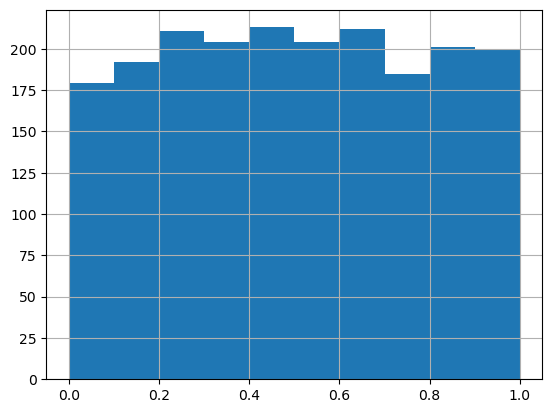

In [10]:
times.hist()

In [11]:
# restrict to later times
time_thresh = 0.9 #0.5
cells_to_use = times > time_thresh

In [12]:
# do clustering
km = KMeans(n_clusters=2,n_init='auto')
y_km = km.fit_predict(expression[cells_to_use])
cluster_assignments = pd.Series(y_km,
                                index=cells_to_use[cells_to_use].index)

In [13]:
cluster_assignments

E1_769       0
E1795_733    1
E645_767     0
E1395_781    1
E395_752     1
            ..
E778_767     0
E1627_773    0
E15_738      0
E534_797     0
E1944_778    1
Length: 199, dtype: int32

In [14]:
expression_clustered = expression[cells_to_use].set_index(cluster_assignments)
expression_binary_clustered = expression_binary[cells_to_use].set_index(cluster_assignments)

In [15]:
expression_binary_clustered.groupby(level=0).mean()

,AMH,CBX2,CTNNB1,DHH,DKK1,DMRT1,FGF9,FOXL2,GATA4,NR0B1,NR5A1,PGD2,RSPO1,SOX9,SRY,UGR,WNT4,WT1mKTS,WT1pKTS
0,1.000000,0.282443,0.312977,1.000000,0.786260,0.793893,1.000000,0.274809,0.503817,0.244275,0.717557,1.000000,0.229008,0.900763,0.793893,0.351145,0.297710,0.458015,0.610687
1,0.264706,0.235294,1.000000,0.235294,0.191176,0.352941,0.279412,1.000000,0.588235,0.691176,0.191176,0.338235,0.926471,0.279412,0.205882,0.426471,0.691176,0.426471,0.308824


## run 'md.distinguishing_nodes_from_attractors' as in DentateGyrus.ipynb

In [16]:
# define a cutoff for on/off: e.g. > 90% cells in cluster are above the median implies ON, 
# < 10% implies OFF, otherwise neither
lower_threshold,upper_threshold = 0.5,0.75 #0.1,0.9
mean_activations = expression_binary_clustered.groupby(level=0).mean()
mean_activations_binary = mean_activations > upper_threshold
mean_activations_binary[(mean_activations > lower_threshold) & (mean_activations < upper_threshold)] = np.nan

In [17]:
# binarize attractors and drop any genes that include "neither" values for any attractor
attractor_groups = [0,1]
attractors_binary = mean_activations_binary.loc[attractor_groups].dropna(axis='columns')

In [18]:
# drop any genes that are constant across all attractors
const_genes = attractors_binary.var()[attractors_binary.var()==0.].index
attractors_binary.drop(const_genes,axis='columns',inplace=True)

In [19]:
attractors_binary

,AMH,CTNNB1,DHH,DKK1,DMRT1,FGF9,FOXL2,PGD2,RSPO1,SOX9,SRY
0,True,False,True,True,True,True,False,True,False,True,True
1,False,True,False,False,False,False,True,False,True,False,False


In [20]:
# put in form recognizable by modularity code
atts = [ [list(state)] for state in np.array(attractors_binary) ]

# set up distinguishing node set generators
dist_gens = md.distinguishing_nodes_from_attractors(atts)

# print results
print("Distinguishing node sets")
for i,gene in enumerate(attractors_binary.index):
    print()
    print(gene)
    print([ attractors_binary.columns[i] for i in dist_gens[i].__next__() ])

Distinguishing node sets

0
['AMH']

1
['AMH']


## modify control kernel code to find _all_ control kernels of size 1

In [21]:
from load_cell_collective_nets import loadCellCollectiveNet
cellcollectivedatadir = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/data'

load_cell_collective_nets WARNING: Cannot import datadex


In [22]:
net = loadCellCollectiveNet('Human_Gonadal_Sex_Determination',cellcollectivedatadir)

In [23]:
# 2023.2.28 NOTE: THERE SEEMS TO BE AN ISSUE WITH THE CONTROL KERNEL CODE INTERFACING WITH THE NEWEST VERSION OF NEET.
# SPECIFICALLY: THE CONTROL KERNEL VERSION OF THE LANDSCAPE CLASS MODIFIES net.attractors WHILE COMPUTING
# CONTROL KERNELS (in md.pinning_produces_desired_attractor).  I DON'T THINK WE TYPICALLY USE NEET'S 
# STANDARD ATTRACTORS FOR THE CONTROL KERNEL STUFF, SO THIS SHOULDN'T AFFECT US MUCH, BUT CAN CAUSE BAD THINGS
# TO HAPPEN IF YOU TRY TO USE net.attractors WHILE ALSO COMPUTING CONTROL KERNELS.
# See github issue here: https://github.com/ELIFE-ASU/Neet/issues/201 
#
# the relevant attractors are the second and third ones
# (to think about: can we also find the all-zero attractor in the simulated data? it has a larger control kernel)
#net.attractors
attractors = md.attractors(net)
attractors

array([[     0],
       [422387],
       [105028]])

In [135]:
# for now we can just manually test every potential control kernel of size 1
for att_index in [1,2]:
    desired_attractor = attractors[att_index].copy()
    desired_attractor_decoded = [net.decode(state) for state in desired_attractor]
    print("Control kernels of size one for attractor {}".format(desired_attractor_decoded))
    for i,name in enumerate(net.names):
        pin = [i,]
        pin_states = [[desired_attractor_decoded[0][i],],]
        if md.pinning_produces_desired_attractor(net,pin,pin_states,desired_attractor):
            print({name})

Control kernels of size one for attractor [[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]]


/Users/bdaniel6/packages/Neet/neet/landscape.py:1118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.attractors = np.asarray(attractor_paths)


{'SRY'}
{'SOX9'}
Control kernels of size one for attractor [[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0]]
{'CTNNB1'}


## 2023.3.3 Can we use our bifurcation detection algorithm?

In [26]:
from landau import landauAnalysis

In [252]:
# do landau analysis on a series of time windows

delta_t = 0.05
Nwindows = 100
landauDataList = []
cells_to_use_list = []
t_min_list = np.linspace(0,1,Nwindows)

for t_min in t_min_list:
    # restrict to varying time window
    t_max = t_min+delta_t
    cells_to_use = (times >= t_min) & (times < t_max)
    cells_to_use_list.append(cells_to_use)
    
    landauData = landauAnalysis.landauAnalysis(expression[cells_to_use])
    landauDataList.append(landauData)

runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv


runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv


runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv
runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv


runLandauTransitionAnalysis: Reading data from /Users/bdaniel6/packages/landau/landau/temp_81855.csv
DEBUG: $ProcessorCount = 8
runLandauTransitionAnalysis: Running analysis...
runLandauTransitionAnalysis: Writing results to temp_81855_LTAoutput.csv


In [238]:
print("Average number of cells in time window: {}".format(np.mean([ c.sum() for c in cells_to_use_list ])))

Average number of cells in time window: 90.9


[(0, -3.049785565426431),
 (1, -12.377873043775084),
 (2, -0.8557379482365501),
 (3, -6.154145535143295),
 (4, -13.180698488173734),
 (5, 3.701741118520708),
 (6, 0.728396869684893),
 (7, -0.05791267097795938),
 (8, -3.30726139417915),
 (9, 0.3602476204002283),
 (10, 0.38332146514356147),
 (11, -1.4203143376175937),
 (12, -2.418889942524676),
 (13, -0.22340743612160097),
 (14, -10.074747464521769),
 (15, -7.679489253360684),
 (16, -25.924133918076617),
 (17, -9.240653442413223),
 (18, -3.9782515100757188),
 (19, -2.0583725284035914),
 (20, 0.9359694505576224),
 (21, 0.6701799887413298),
 (22, -5.385333934245486),
 (23, -2.597904917884832),
 (24, 4.080679711445081),
 (25, -4.131024636480625),
 (26, -1.0979521500337475),
 (27, -1.0206580340877132),
 (28, -6.524758474184939),
 (29, -13.434378698736243),
 (30, -7.534803693196207),
 (31, -15.137362215945895),
 (32, -27.584655282924906),
 (33, -48.18098176227769),
 (34, -59.16628536271993),
 (35, -74.01280660406158),
 (36, -58.45503216148867

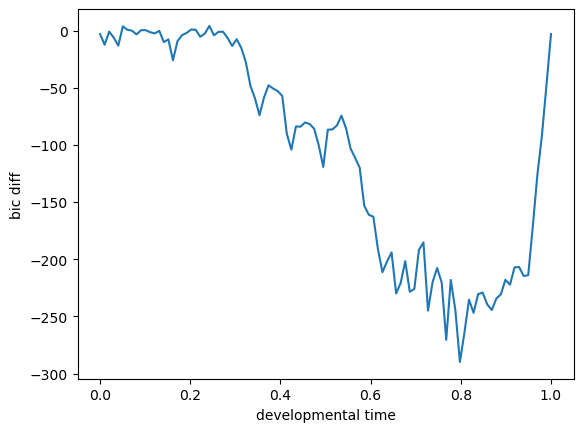

In [259]:
# bicDiff less than -6 indicates strong evidence of a post-transition state
plt.plot(t_min_list,
         [landauData['bicDiffList'][0] for landauData in landauDataList])
plt.xlabel('developmental time')
plt.ylabel('bic diff')
[(i,landauData['bicDiffList'][0]) for i,landauData in enumerate(landauDataList)]

In [370]:
# compute `s` values --- fraction of each gene's variance along first eigenvector --- at first bistable point
transitionIndex = 28 #29
expression_slice = expression[cells_to_use_list[transitionIndex]]
vals,vecs = principalComponents(expression_slice)
pc = pd.Series(vecs[0], index=expression.columns)
variances = pd.Series(np.diag(expression_slice.cov(ddof=0)), index=expression.columns)
Jnu = landauDataList[transitionIndex]['valList'][0]
s = pc**2 / Jnu / variances

<AxesSubplot: >

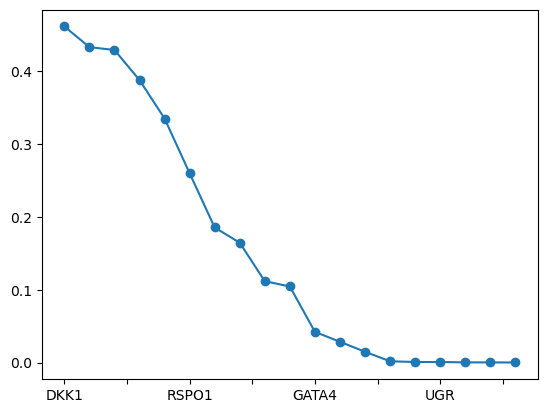

In [382]:
abs(pc).sort_values(ascending=False).plot(marker='o')

In [371]:
s.sort_values(ascending=False)[:4]

DKK1      0.554395
CTNNB1    0.537316
DMRT1     0.535871
SRY       0.465346
dtype: float64

In [365]:
# set transition indices to use in visualizations
transitionIndexList = [24,28,50] #[24,28,36]

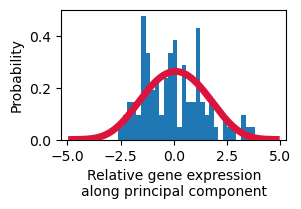

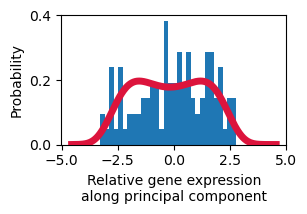

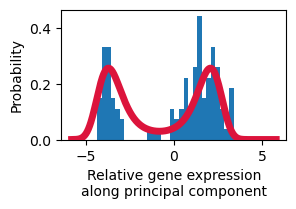

In [366]:
for transitionIndex in transitionIndexList:
    plt.figure(figsize=(3,2))
    expression_slice = expression[cells_to_use_list[transitionIndex]]
    Jvals = landauDataList[transitionIndex]['valList']
    Jvecs = landauDataList[transitionIndex]['vecList']
    c = landauDataList[transitionIndex]['cList'][0]
    d = landauDataList[transitionIndex]['dList'][0]
    nuMu = landauDataList[transitionIndex]['nuMuList'][0]
    bistablePlot(expression_slice,Jvecs[0],Jvals,Jvecs,c,d,nuMu,plotGaussian=False)
    plt.xlabel('Relative gene expression\nalong principal component')
    plt.subplots_adjust(bottom=0.3,top=0.95,left=0.2,right=0.95)
    plt.savefig('230306_GSD_simulated_bistability_index{}.pdf'.format(transitionIndex))

In [257]:
# compute s values for all time windows
sList = []
for transitionIndex in range(len(t_min_list)):
    expression_slice = expression[cells_to_use_list[transitionIndex]]
    vals,vecs = principalComponents(expression_slice)
    pc = pd.Series(vecs[0], index=expression.columns)
    variances = pd.Series(np.diag(expression_slice.cov(ddof=0)), index=expression.columns)
    Jnu = landauDataList[transitionIndex]['valList'][0]
    s = pc**2 / Jnu / variances
    sList.append(s)

In [389]:
# print genes with largest s for highlighted time windows
for transitionIndex in transitionIndexList:
    print("t = {}".format(t_min_list[transitionIndex]))
    print(sList[transitionIndex].sort_values(ascending=False)[:4])
    print()

t = 0.24242424242424243
CTNNB1    0.480644
SRY       0.426989
DMRT1     0.355821
RSPO1     0.328446
dtype: float64

t = 0.2828282828282829
DKK1      0.554395
CTNNB1    0.537316
DMRT1     0.535871
SRY       0.465346
dtype: float64

t = 0.5050505050505051
CTNNB1    0.871553
FOXL2     0.820387
RSPO1     0.803390
WNT4      0.671332
dtype: float64



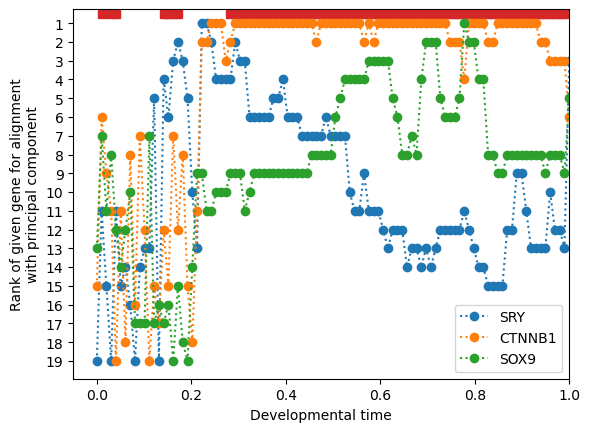

In [386]:
# plot rank of known control kernel nodes as a function of developmental time
for gene_name in ['SRY','CTNNB1','SOX9']: #,'DKK1']:
#for gene_name in ['UGR']: #,'DKK1']:
    plt.plot(t_min_list,
             [ s.rank(ascending=False)[gene_name] for s in sList ],
             'o:',label=gene_name)
plt.legend()
plt.xlabel('Developmental time')
plt.ylabel('Rank of given gene for alignment\nwith principal component')

# indicate which cases show evidence of bistability
BICthresh = -6
yVal = 0.5
plt.plot(t_min_list,
         [(landauData['bicDiffList'][0] < BICthresh)*yVal for landauData in landauDataList],
         's',
         zorder=-10)

plt.axis(xmax=1,ymin=0.25)
plt.yticks(range(1,20))
plt.gca().invert_yaxis()

## 2023/3/8 make some plots for the grant proposal

In [296]:
from sklearn.manifold import TSNE

In [323]:
perplexity = 300 # 30
expressionTSNE = TSNE(perplexity=perplexity).fit_transform(expression)

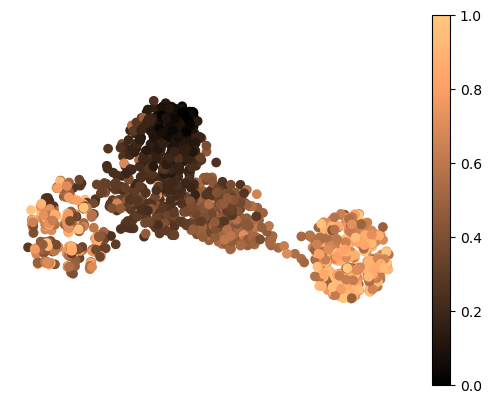

In [354]:
plt.scatter(expressionTSNE[:,0],
            expressionTSNE[:,1],
            c=times,cmap='copper')
plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.savefig('230308_GSD_simulated_TSNE_vs_time.pdf')

time = 0.24242424242424243
time = 0.2828282828282829
time = 0.36363636363636365


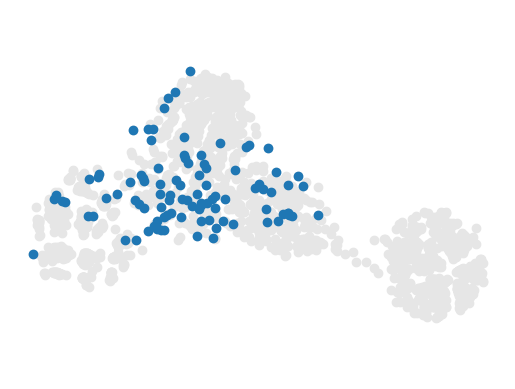

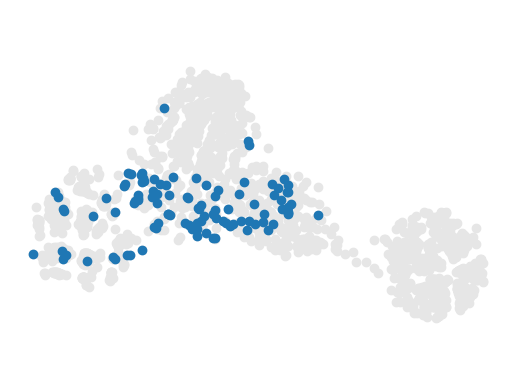

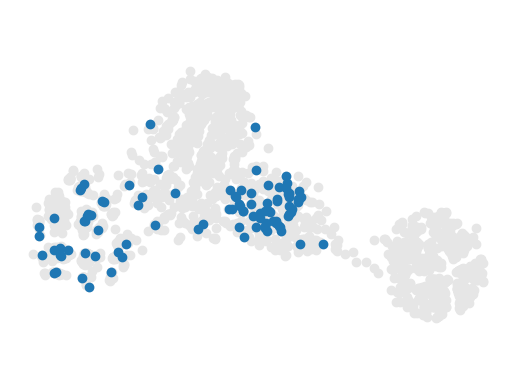

In [356]:
for time_index in transitionIndexList:
    plt.figure()
    plt.scatter(expressionTSNE[:,0],
                expressionTSNE[:,1],
                c='0.9')
    plt.scatter(expressionTSNE[cells_to_use_list[time_index]][:,0],
                expressionTSNE[cells_to_use_list[time_index]][:,1],
                c='C0')
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('230308_GSD_simulated_TSNE_index{}.pdf'.format(time_index))
    print("time = {}".format(t_min_list[time_index]))

In [357]:
vals,vecs = principalComponents(expression)
projected0 = np.dot(expression,vecs[0])
projected1 = np.dot(expression,vecs[1])

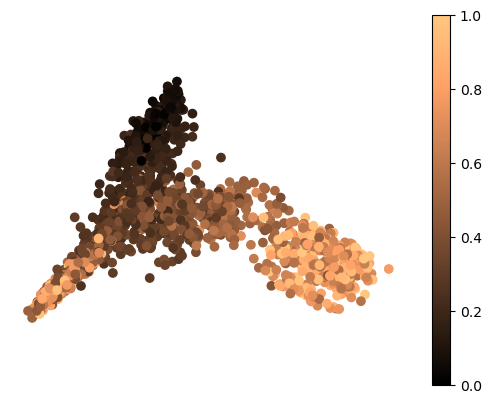

In [369]:
plt.scatter(projected0,projected1,c=times,cmap='copper')
plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.savefig('230308_GSD_simulated_PCA_vs_time.pdf')

time = 0.24242424242424243
time = 0.2828282828282829
time = 0.5050505050505051


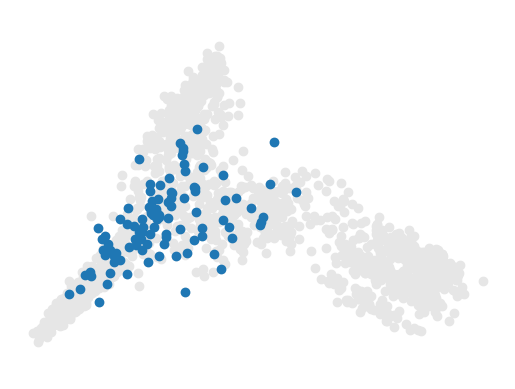

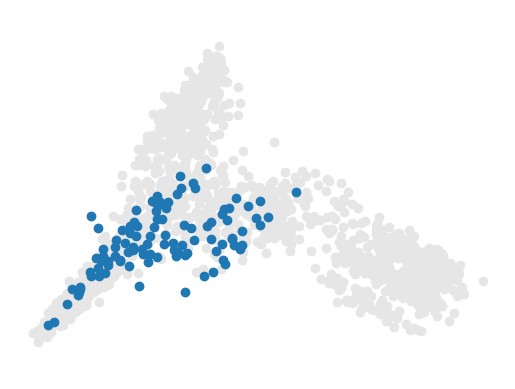

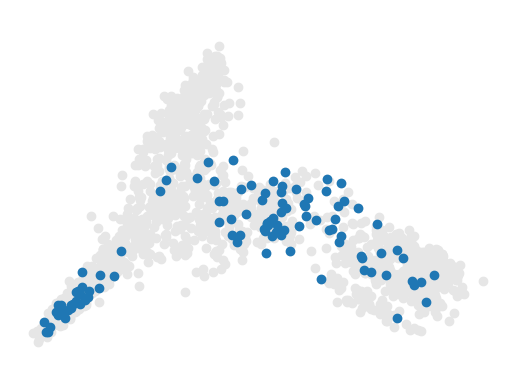

In [368]:
for time_index in transitionIndexList:
    plt.figure()
    plt.scatter(projected0,
                projected1,
                c='0.9')
    plt.scatter(projected0[cells_to_use_list[time_index]],
                projected1[cells_to_use_list[time_index]],
                c='C0')
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('230308_GSD_simulated_PCA_index{}.pdf'.format(time_index))
    print("time = {}".format(t_min_list[time_index]))